In [1]:
# Read data from DataMapWales
from owslib.wms import WebMapService

# Standard Imports
import os
import cv2
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [36]:
def fetch_wms_data(wms_url, width, height, srs="EPSG:4326", format="image/png", version="1.3.0"):
    """
    Fetches map data from a WMS endpoint.

    Parameters:
        wms_url (str): The URL of the WMS endpoint.
        size (tuple): The width and height (respectively) of the requested image in pixels.
        srs (str): The spatial reference system (default is "EPSG:4326").
        format (str): The format of the returned image (default is "image/png").
        version (str): The WMS version to use (default is "1.3.0").

    Returns:
        bytes: The raw image data returned by the WMS service.
    """
    try:
        def get_response(layer_name, bbox):
            # Fetch the map data
            print(f"Fetching layer: {layer_name}")
            response = wms.getmap(
                layers=[layer_name],
                srs=srs,
                bbox=bbox,
                size=(width, height),
                format=format,
                transparent=True
            )
            return response.read()
        
        # Initialize the WMS service
        wms = WebMapService(wms_url, version=version)

        layers = list(wms.contents)
        
        # Check contents of the WMS service
        print("Available Layers: ", layers)
        
        if len(layers) == 0:
            print("No layers available in the WMS service.")
            return None
        elif len(layers) == 1:
            layer = layers[0]
            return get_response(layer, wms[layer].boundingBox)
        elif len(layers) > 1:
            response_list = []
            for layer in layers:
                response_list.append(get_response(layer,wms[layer].boundingBox))
            return response_list
        else: 
            print("An unexpected error occurred: No layers found.")
            return None
        
    except Exception as e:
        print(f"An error occurred while fetching WMS data: {e}")
        return None
        
def save_image(image_data):
    """
    Converts image byte data into NumPy arrays.

    Parameters:
        image_data_list (list or bytes): A list of byte data representing images or a single image byte data.

    Returns:
        list or np.ndarray: A list of NumPy arrays if multiple images are provided, or a single NumPy array if only one image is provided.
    """
    try:
        # If the input is a single image (not a list), wrap it in a list for processing
        if isinstance(image_data, bytes):
            image_data = [image_data]

        numpy_images = []
        for i, img_data in enumerate(image_data):
            # Decode the image byte data into a NumPy array
            numpy_image = cv2.imdecode(np.frombuffer(img_data, np.uint8), cv2.IMREAD_UNCHANGED)
            
            # Save the images
            cv2.imwrite(f"output{i}.png", numpy_image)  # Save the image for debugging
            
            # append the NumPy array to the list
            numpy_images.append(numpy_image)
            
        # Return a single NumPy array if only one image was provided
        return numpy_images[0] if len(numpy_images) == 1 else numpy_images
    except Exception as e:
        print(f"An error occurred while converting images to NumPy arrays: {e}")
        return None
            
def overlay_images(image_data_list, alpha=0.5):
    """
    Overlays multiple images with adjustable transparency.

    Parameters:
        image_data_list (list): A list of byte data representing images.
        alpha (float): The transparency factor for blending (0.0 to 1.0).

    Returns:
        np.ndarray: The resulting overlaid image as a NumPy array.
    """
    try:
        # Decode the first image
        base_image = cv2.imdecode(np.frombuffer(image_data_list[0], np.uint8), cv2.IMREAD_UNCHANGED)

        # Iterate through the remaining images and overlay them
        for img_data in image_data_list[1:]:
            overlay_image = cv2.imdecode(np.frombuffer(img_data, np.uint8), cv2.IMREAD_UNCHANGED)
            
            # Ensure the images have the same dimensions
            if base_image.shape != overlay_image.shape:
                overlay_image = cv2.resize(overlay_image, (base_image.shape[1], base_image.shape[0]))

            # Blend the images
            base_image = cv2.addWeighted(base_image, alpha, overlay_image, 1 - alpha, 0)
            
        # Save the image
        cv2.imwrite("output_overlay.png", base_image)
        return base_image
    except Exception as e:
        print(f"An error occurred while overlaying images: {e}")
        return None

In [37]:
wms_url = "https://datamap.gov.wales/capabilities/map/scheduled-monuments-and-sssi/?ows_service=wms"
output = fetch_wms_data(wms_url, width = 800, height = 600)
raw_output = save_image(output)
overlay_output = overlay_images(output)

Available Layers:  ['geonode:wales_lidar_dsm_1m_hillshade_multi_cog', 'inspire-wg:Cadw_SAM', 'inspire-nrw:NRW_SSSI']
Fetching layer: geonode:wales_lidar_dsm_1m_hillshade_multi_cog
Fetching layer: inspire-wg:Cadw_SAM
Fetching layer: inspire-nrw:NRW_SSSI


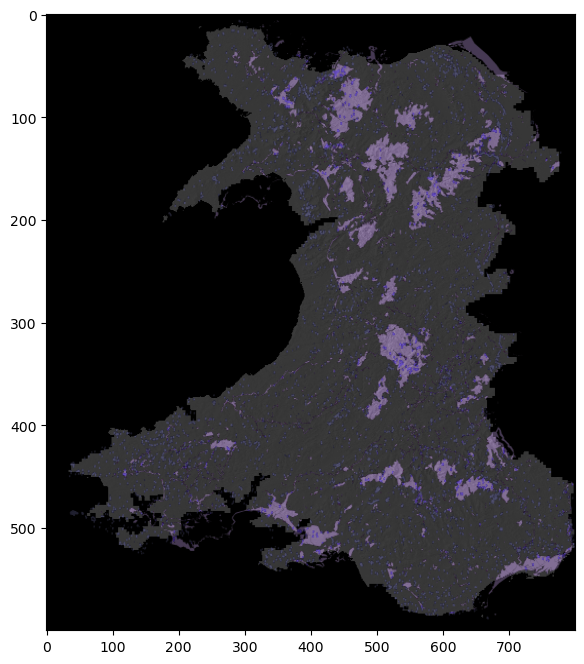

In [64]:
tot = len(raw_output) + 1
fig = plt.figure(figsize=(15, 8))  # Basic Figure Setup
# Add Overlay Image
ax = fig.add_subplot(1, 2, 1)
ax.set_facecolor((0., 0., 0.))
ax.imshow(overlay_output, aspect='auto')
plt.show()